# 多项式回归


In [10]:
import math
import torch
import numpy as np
from torch import nn



max_degree = 20
n_train, n_test = 100, 10
true_w = np.zeros(max_degree)
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])  # 真实模型参数
features = np.random.normal(size=(n_train + n_test, 1))  # 生成随机输入
np.random.shuffle(features)

# np.power: 计算输入数组元素的指定次幂
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))  # 生成多项式特征



In [11]:
features

array([[ 0.59956181],
       [ 0.26274247],
       [-0.81285098],
       [-0.48835455],
       [ 1.23005088],
       [-0.75528673],
       [-0.34398942],
       [-0.61170173],
       [-1.51761166],
       [-0.71465167],
       [ 0.247841  ],
       [ 0.55410468],
       [ 0.9796591 ],
       [ 0.0132917 ],
       [ 0.87471117],
       [-1.18142108],
       [-1.17120886],
       [ 0.17692864],
       [ 1.25069063],
       [ 0.49939521],
       [ 0.66579483],
       [ 0.04813315],
       [-0.65011729],
       [ 1.20291295],
       [ 0.41914907],
       [-0.01464874],
       [ 0.02365993],
       [-0.23585859],
       [-0.23222362],
       [ 0.75026359],
       [-0.23328566],
       [-0.27351975],
       [-0.55162837],
       [-2.074694  ],
       [ 1.436883  ],
       [-0.44323095],
       [-1.1261409 ],
       [-0.73138985],
       [-0.26292609],
       [ 1.02845777],
       [ 2.40760001],
       [ 0.14242607],
       [-0.67714014],
       [-0.74918938],
       [ 0.95564357],
       [-0

In [12]:
poly_features

array([[ 1.00000000e+00,  5.99561807e-01,  3.59474360e-01, ...,
         1.67177304e-04,  1.00233127e-04,  6.00959545e-05],
       [ 1.00000000e+00,  2.62742471e-01,  6.90336061e-02, ...,
         1.35523548e-10,  3.56077920e-11,  9.35567926e-12],
       [ 1.00000000e+00, -8.12850983e-01,  6.60726721e-01, ...,
        -2.95247276e-02,  2.39992039e-02, -1.95077765e-02],
       ...,
       [ 1.00000000e+00,  2.02610789e-01,  4.10511316e-02, ...,
         1.63404358e-12,  3.31074858e-13,  6.70793380e-14],
       [ 1.00000000e+00,  3.04746378e-01,  9.28703548e-02, ...,
         1.68637979e-09,  5.13918133e-10,  1.56614689e-10],
       [ 1.00000000e+00,  1.61323456e-01,  2.60252575e-02, ...,
         3.39514088e-14,  5.47715861e-15,  8.83594156e-16]])

In [15]:
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)  # 使用gamma函数对特征进行归一化，gamma(n)=(n-1)!

# np.dot: 矩阵点积
labels = np.dot(poly_features, true_w)  # 生成标签
labels += np.random.normal(scale=0.1, size=labels.shape)  # 添加噪声

In [16]:
labels.shape

(110,)

In [17]:
poly_features.shape

(110, 20)

In [22]:
true_w.shape

(20,)

In [23]:
# 转换为张量
true_w,features,poly_features,labels = [torch.tensor(i, dtype=torch.float32) for i in [true_w,features,poly_features,labels]]

In [32]:


from traintools import Accumulator, load_array, train_model


def evaluate_loss(net, data_iter, loss):
    """评估模型在数据迭代器上的损失"""
    metric = Accumulator(2)  # 累加器，用于存储总损失和样本数
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]  # 返回平均损失

def train(train_features,test_features,train_labels,test_labels,num_epochs=400):
    """训练模型"""
    loss = nn.MSELoss()  # 均方误差损失函数
    input_shape = train_features.shape[-1]  # 输入特征的维度
    net = nn.Sequential(nn.Linear(input_shape, 1,bias=False))  # 定义线性，不设置偏置，作为多项式零次存在
    batch_size = min(10, train_labels.shape[0])

    # train_labels.reshape(-1,1) 的意思是将 train_labels 转换为一个二维张量，其中-1表示该维度的大小由程序自动计算，以保证元素的总数不变，而 1 表示第二个维度的大小为 1。这样做的目的是将 train_labels 转换为一个列向量，使其能够与模型的输出进行比较和计算损失
    train_iter = load_array((train_features,train_labels.reshape(-1,1)),batch_size,is_train=True)
    test_iter = load_array((test_features,test_labels.reshape(-1,1)),batch_size,is_train=False)

    trainer = torch.optim.SGD(net.parameters(), lr=0.01)

    train_model(net, train_iter, test_iter, loss, trainer,num_epochs=num_epochs,early_stopping_patience=999)

    print('weights:', net[0].weight.data.cpu().numpy().flatten())


Epoch [1/400], Train Loss: 20.1312, Test Loss: 19.2084, Test Accuracy: 0.0000
Epoch [2/400], Train Loss: 13.3507, Test Loss: 12.9671, Test Accuracy: 0.0000
Epoch [3/400], Train Loss: 9.0449, Test Loss: 8.8389, Test Accuracy: 0.0000
Epoch [4/400], Train Loss: 6.2689, Test Loss: 6.1041, Test Accuracy: 0.0000
Epoch [5/400], Train Loss: 4.4685, Test Loss: 4.2964, Test Accuracy: 0.0000
Epoch [6/400], Train Loss: 3.3118, Test Loss: 3.0839, Test Accuracy: 0.0000
Epoch [7/400], Train Loss: 2.5517, Test Loss: 2.2541, Test Accuracy: 0.0000
Epoch [8/400], Train Loss: 2.0495, Test Loss: 1.6876, Test Accuracy: 0.0000
Epoch [9/400], Train Loss: 1.7152, Test Loss: 1.2989, Test Accuracy: 0.0000
Epoch [10/400], Train Loss: 1.4873, Test Loss: 1.0260, Test Accuracy: 0.0000
Epoch [11/400], Train Loss: 1.3258, Test Loss: 0.8275, Test Accuracy: 0.0000
Epoch [12/400], Train Loss: 1.2088, Test Loss: 0.6827, Test Accuracy: 0.0000
Epoch [13/400], Train Loss: 1.1216, Test Loss: 0.5788, Test Accuracy: 0.0000
Epoc

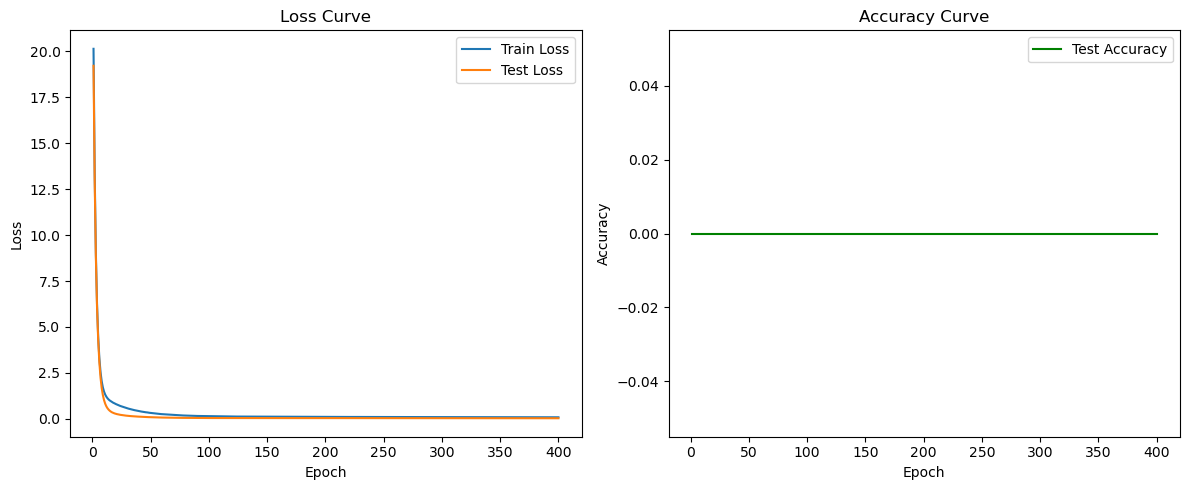

Model weights saved to: ./models\model_20250809_010436.pth
Full model saved to: ./models\model_20250809_010436.pt
weights: [ 4.897285   1.5360576 -2.666454   0.5985169]


In [33]:
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:], num_epochs=400)

Epoch [1/400], Train Loss: 22.0494, Test Loss: 20.7783, Test Accuracy: 0.0000
Epoch [2/400], Train Loss: 14.7945, Test Loss: 14.0585, Test Accuracy: 0.0000
Epoch [3/400], Train Loss: 10.0342, Test Loss: 9.6061, Test Accuracy: 0.0000
Epoch [4/400], Train Loss: 6.9085, Test Loss: 6.6189, Test Accuracy: 0.0000
Epoch [5/400], Train Loss: 4.8457, Test Loss: 4.6176, Test Accuracy: 0.0000
Epoch [6/400], Train Loss: 3.4848, Test Loss: 3.2600, Test Accuracy: 0.0000
Epoch [7/400], Train Loss: 2.5833, Test Loss: 2.3438, Test Accuracy: 0.0000
Epoch [8/400], Train Loss: 1.9911, Test Loss: 1.7181, Test Accuracy: 0.0000
Epoch [9/400], Train Loss: 1.6041, Test Loss: 1.2880, Test Accuracy: 0.0000
Epoch [10/400], Train Loss: 1.3430, Test Loss: 0.9917, Test Accuracy: 0.0000
Epoch [11/400], Train Loss: 1.1736, Test Loss: 0.7860, Test Accuracy: 0.0000
Epoch [12/400], Train Loss: 1.0625, Test Loss: 0.6400, Test Accuracy: 0.0000
Epoch [13/400], Train Loss: 0.9909, Test Loss: 0.5349, Test Accuracy: 0.0000
Epo

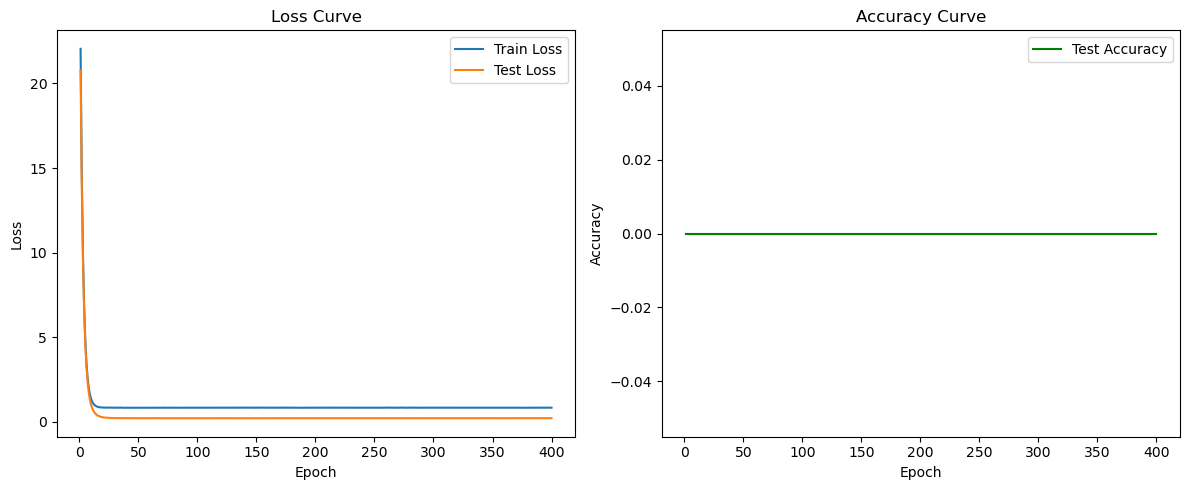

Model weights saved to: ./models\model_20250809_011905.pth
Full model saved to: ./models\model_20250809_011905.pt
weights: [4.3890376 1.1188229]


In [34]:
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:], num_epochs=400)

Epoch [1/1500], Train Loss: 17.6322, Test Loss: 17.0530, Test Accuracy: 0.0000
Epoch [2/1500], Train Loss: 11.7998, Test Loss: 11.5563, Test Accuracy: 0.0000
Epoch [3/1500], Train Loss: 8.0551, Test Loss: 7.9448, Test Accuracy: 0.0000
Epoch [4/1500], Train Loss: 5.6529, Test Loss: 5.5457, Test Accuracy: 0.0000
Epoch [5/1500], Train Loss: 4.1023, Test Loss: 3.9411, Test Accuracy: 0.0000
Epoch [6/1500], Train Loss: 3.0891, Test Loss: 2.8562, Test Accuracy: 0.0000
Epoch [7/1500], Train Loss: 2.4259, Test Loss: 2.1158, Test Accuracy: 0.0000
Epoch [8/1500], Train Loss: 1.9769, Test Loss: 1.6022, Test Accuracy: 0.0000
Epoch [9/1500], Train Loss: 1.6801, Test Loss: 1.2494, Test Accuracy: 0.0000
Epoch [10/1500], Train Loss: 1.4783, Test Loss: 1.0000, Test Accuracy: 0.0000
Epoch [11/1500], Train Loss: 1.3313, Test Loss: 0.8129, Test Accuracy: 0.0000
Epoch [12/1500], Train Loss: 1.2174, Test Loss: 0.6764, Test Accuracy: 0.0000
Epoch [13/1500], Train Loss: 1.1346, Test Loss: 0.5767, Test Accuracy

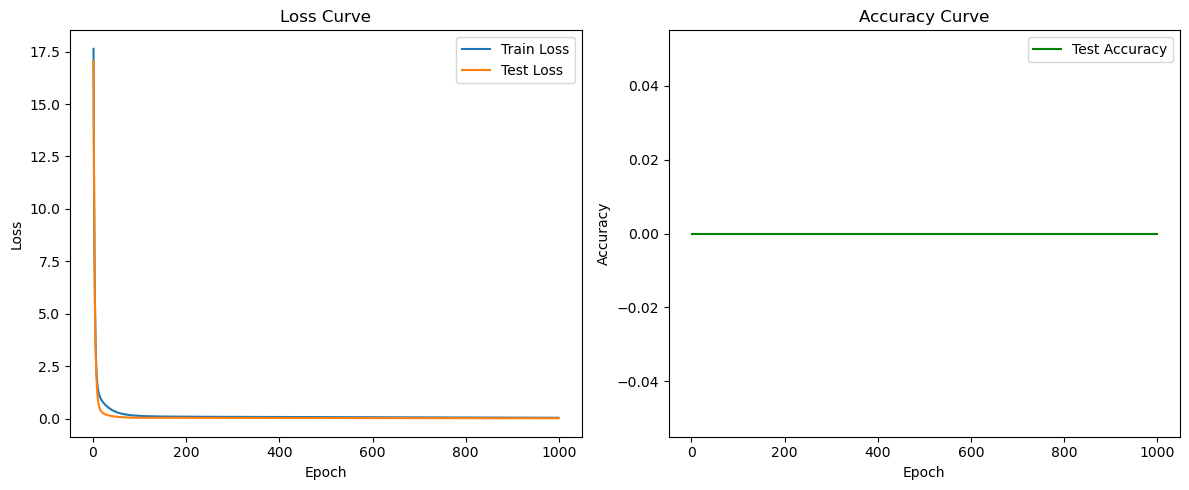

Model weights saved to: ./models\model_20250809_012003.pth
Full model saved to: ./models\model_20250809_012003.pt
weights: [ 4.9364295   1.4133451  -2.9628053   2.4321725   0.29196796 -0.13092972
  0.05194785 -0.16351119  0.03143715 -0.12828985  0.11957026 -0.17056939
  0.17258185 -0.08547027  0.04708922 -0.2212853  -0.214206    0.06932661
 -0.21079499  0.20478222]


In [35]:
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)